# Global Stuffs

In [189]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import re

## functions

In [190]:
def set_plot_style(axs, fonts, xlabel, ylabel):
    axs.set_xlabel(xlabel, fontsize=fonts)
    axs.set_ylabel(ylabel, fontsize=fonts)
    axs.tick_params(axis='both', which='major', direction='out', length=4, width=1)
    axs.tick_params(which='minor', width=1, size=2)  # Adjust size as needed
    axs.minorticks_on() # Turn on minor ticks
    
    #axs.grid(False, which='both', axis='both', linestyle='--', linewidth=0.5)
    axs.set_facecolor('white')
    axs.spines['top'].set_linewidth(1)
    axs.spines['right'].set_linewidth(1)
    axs.spines['bottom'].set_linewidth(1)
    axs.spines['left'].set_linewidth(1)
    axs.tick_params(axis='x', labelsize=fonts)
    axs.tick_params(axis='y', labelsize=fonts)

    return axs

def darken_colors(num_colors, darker_factor=0.7):
    colors = plt.cm.jet(np.linspace(0, 1, num_colors))
    darker_colors = colors.copy()

    for i in range(num_colors):
        rgb = darker_colors[i, :3]
        hsv = plt.cm.colors.rgb_to_hsv(rgb)
        hsv[2] *= darker_factor
        darker_colors[i, :3] = plt.cm.colors.hsv_to_rgb(hsv)

    return darker_colors


def create_label(filename):
    # Only modify if any target patterns exist
    if any(x in filename for x in ['thresh1_', 'f_', 'azimuthal', 'P3HB', 'rep_', '_01', 'subtracted_avg_']):
        label = filename.split('.')[0]
        label = label.replace('thresh1_', '').split('_Scan')[0]
        label = label.split('f_')[-1] if 'f_' in label else label
        label = label.split('_azimuthal')[0] if 'azimuthal' in label else label
        label = label.replace('P3HB', 'PHA-3B')
        label = label.replace('rep_', '').replace('_01', '')
        label = label.replace('subtracted_avg_', '')
    else:
        label = filename.split('.')[0]  # just remove extension, no other changes
    return label


## read and plot excel files

# tensile function

In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime


def plot_measured_data(file_path, file_name, y_column):
    try:
        full_path = f"{file_path}/{file_name}"
        df = pd.read_csv(full_path)
        
        if 'time' not in df.columns:
            raise ValueError("The file must contain a 'time' column.")
        if y_column not in df.columns:
            raise ValueError(f"The specified y_column '{y_column}' is not in the data.")
        
        df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
        df.dropna(subset=['time'], inplace=True)

        x_time = df['time']
        y_values = df[y_column]

        '''
        fig, ax = plt.subplots(figsize=(10, 6))
        plt.plot(x_time, y_values, marker='o')
        set_plot_style(ax, 14, 'time', y_column)
        ax.set_title(f"{y_column} vs time", fontsize=16)

        # Set x-axis ticks to only start, middle, and end time
        times = x_time.sort_values()
        start = times.iloc[0]
        end = times.iloc[-1]
        mid_idx = len(times) // 2
        mid = times.iloc[mid_idx]

        ax.set_xticks([start, mid, end])
        ax.set_xticklabels([
            start.strftime('%Y-%m-%d') + '\n' + start.strftime('%H:%M:%S'),
            mid.strftime('%Y-%m-%d') + '\n' + mid.strftime('%H:%M:%S'),
            end.strftime('%Y-%m-%d') + '\n' + end.strftime('%H:%M:%S')
        ], rotation=45)

        plt.tight_layout()
        plt.show()
        '''
    except FileNotFoundError:
        print(f"File '{full_path}' not found. Please provide a valid file path and name.")
    except ValueError as e:
        print(e)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

        
    
    return x_time, y_values



if __name__ == "__main__":
# Specify the file path and file name to read
    #file_path = r"C:\Users\checkout\Documents\Anjani\Redesigned_Plastics\Dec2024_BL172\TS600_Scripts"  # Example fixed path
    file_path_tensile = r"/Users/akmaurya/OneDrive - Stanford/Data_01/Redesigned_Plastics/Dec_2024/Anjani/Redesigned_Plastics/Dec2024_BL172/TS600_Scripts"  # Example fixed path
    file_name = "insitu_Run2_LDPE_5mmmin_01.csv"
    #file_name = "insitu_Run6_PHPD_Film_base_5mmmin_01.csv"
    file_name = "insitu_Run8_PHPD_Film_base_3mmmin_01.csv"

    #file_name = "insitu_Run9_PHPD_MBfilm_3mmmin_01.csv"
    #file_name = 'insitu_Run10_P5HV_film_3mmmin_01.csv'

    #file_name = "insitu_Run15_P5HV_film_3mmmin_01.csv"

    #file_name = "insitu_Run16_LDPE_film_3mmmin_01.csv"
    #file_name = 'insitu_Run17_P5HV_film_5mmmin_01.csv'
   
    x_time, y_values = plot_measured_data(file_path_tensile, file_name, y_column="force")

    print (x_time)

0      2024-12-19 04:39:40.661566
1      2024-12-19 04:39:41.332070
2      2024-12-19 04:39:41.683769
3      2024-12-19 04:39:42.019199
4      2024-12-19 04:39:42.503958
                  ...            
1177   2024-12-19 04:49:42.989232
1178   2024-12-19 04:49:43.330326
1179   2024-12-19 04:49:44.002412
1180   2024-12-19 04:49:44.346162
1181   2024-12-19 04:49:45.033656
Name: time, Length: 1182, dtype: datetime64[ns]


## waxs crytallinity paramter

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def extract_WAXS_crystallinity_parameters(folder_path, filename):
    """
    Reads a specific Excel file, extracts each column (except the first datetime column),
    returns them as a dictionary where keys are column names, and plots each column individually.

    Parameters:
    folder_path (str): Path to the folder containing Excel files.
    filename (str): Specific Excel file to process.

    Returns:
    dict: A dictionary with column names as keys and Pandas Series as values.
    """
    column_data = {}

    file_path = os.path.join(folder_path, filename)
    if not (os.path.exists(file_path) and filename.endswith((".xlsx", ".xls"))):
        print(f"❌ File not found or not an Excel file: {filename}")
        return column_data

    print(f"\n📂 Processing file: {filename}")
    try:
        df = pd.read_excel(file_path)

        # Convert first column to datetime and set as index
        df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors='coerce')
        df.dropna(subset=[df.columns[0]], inplace=True)
        df.set_index(df.columns[0], inplace=True)

       
        # Extract each column as Series and store with its name
        for col in df.columns:
            series = df[col]
            column_data[col] = series
            '''
            # Plot each column
            plt.figure(figsize=(10, 4))
            plt.plot(series.index, series.values, label=col)
            plt.xlabel("Time")
            plt.ylabel(col)
            plt.title(f"{col} vs Time")
            plt.grid(True)
            plt.tight_layout()
            plt.legend()
            plt.show()
        '''
    except Exception as e:
        print(f"❌ Failed to process {filename}: {e}")

    return column_data




# combine plot

In [193]:

folder_path_waxs = '/Volumes/SSD1/RawData1/Redesigned_Plastics/Dec2024/OneD_integrated_WAXS_01/insitu/Subtracted_Data/Final_analysis/'

file_path_tensile = r"/Users/akmaurya/OneDrive - Stanford/Data_01/Redesigned_Plastics/Dec_2024/Anjani/Redesigned_Plastics/Dec2024_BL172/TS600_Scripts"  # Example fixed path
    

In [200]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_waxs_with_tensile_overlay(folder_path_waxs, filename_waxs,
                                   file_path_tensile, filename_tensile,
                                   vertical_line_time_str,
                                   fonts=16):
    # --- Load WAXS data ---
    crystallinity_data = extract_WAXS_crystallinity_parameters(folder_path_waxs, filename=filename_waxs)

    # --- Load Tensile data ---
    x_time, force = plot_measured_data(file_path_tensile, filename_tensile, y_column="force")

    #x_time, y_values = plot_measured_data(file_path_tensile, filename_tensile, y_column="enlogation")

    # --- Extract WAXS parameters ---
    date_time = crystallinity_data['percentage_crystallinity'].index
    crystallinity = crystallinity_data['percentage_crystallinity']
    size = crystallinity_data['crystallite_size']
    d_spacing = crystallinity_data['d_spacing']

    # --- Convert vertical line string to datetime ---
    vertical_line_time = pd.to_datetime(vertical_line_time_str)

    # --- Create subplots with shared x-axis ---
    fig, axs = plt.subplots(3, 1, figsize=(7, 9), sharex=True)

    # --- Plot Crystallinity ---
    axs[0].plot(date_time, crystallinity, '.-',color='tab:blue')
    axs[0].axvline(x=vertical_line_time, color='black', linestyle='--')
    ax0_twin = axs[0].twinx()
    ax0_twin.plot(x_time, force, color='tab:gray', alpha=0.5)
    set_plot_style(axs[0], fonts, '', 'Crystallinity (%)')
    set_plot_style(ax0_twin, fonts, '', 'Force (N)')
    ax0_twin.tick_params(axis='y', labelcolor='tab:gray')
    ax0_twin.yaxis.label.set_color('tab:gray')  # <-- Set y-axis label to gray

    # --- Plot Crystallite Size ---
    axs[1].plot(date_time, size, '.-',color='tab:green')
    axs[1].axvline(x=vertical_line_time, color='black', linestyle='--')
    ax1_twin = axs[1].twinx()
    ax1_twin.plot(x_time, force, color='tab:gray', alpha=0.5)
    set_plot_style(axs[1], fonts, '', 'Crystallite Size (nm)')
    set_plot_style(ax1_twin, fonts, '', 'Force (N)')
    ax1_twin.tick_params(axis='y', labelcolor='tab:gray')
    ax1_twin.yaxis.label.set_color('tab:gray')  # <-- Set y-axis label to gray

    # --- Plot d-spacing ---
    axs[2].plot(date_time, d_spacing, '.-',color='tab:red')
    axs[2].axvline(x=vertical_line_time, color='black', linestyle='--')
    ax2_twin = axs[2].twinx()
    ax2_twin.plot(x_time, force, color='tab:gray', alpha=0.5)
    set_plot_style(axs[2], fonts, 'WAXS Time', 'd-spacing (nm)')
    set_plot_style(ax2_twin, fonts, '', 'Force (N)')
    ax2_twin.tick_params(axis='y', labelcolor='tab:gray')
    ax2_twin.yaxis.label.set_color('tab:gray')  # <-- Set y-axis label to gray

    # --- Format x-axis ticks ---
    if len(date_time) >= 3:
        xticks = [date_time[0], date_time[len(date_time) // 2], date_time[-1]]
        axs[2].set_xticks(xticks)
        axs[2].set_xticklabels(
            [xtick.strftime('%Y-%m-%d\n%H:%M:%S') for xtick in xticks],
            rotation=0
        )

    # --- Final layout and show ---
    plt.tight_layout()
    plt.show()


## Inputs

## LDPE


📂 Processing file: crystallinity_Run2_LDPE_5mmmin_01_Scan00001_s00419.xlsx


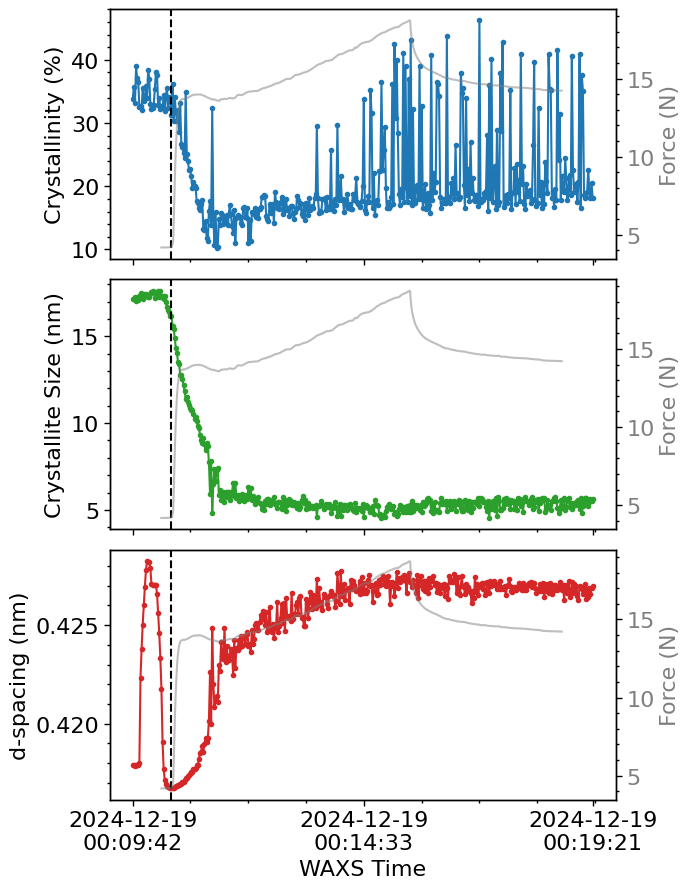


📂 Processing file: crystallinity_Run16_LDPE_film_3mmmin_01_Scan00001_s00599.xlsx


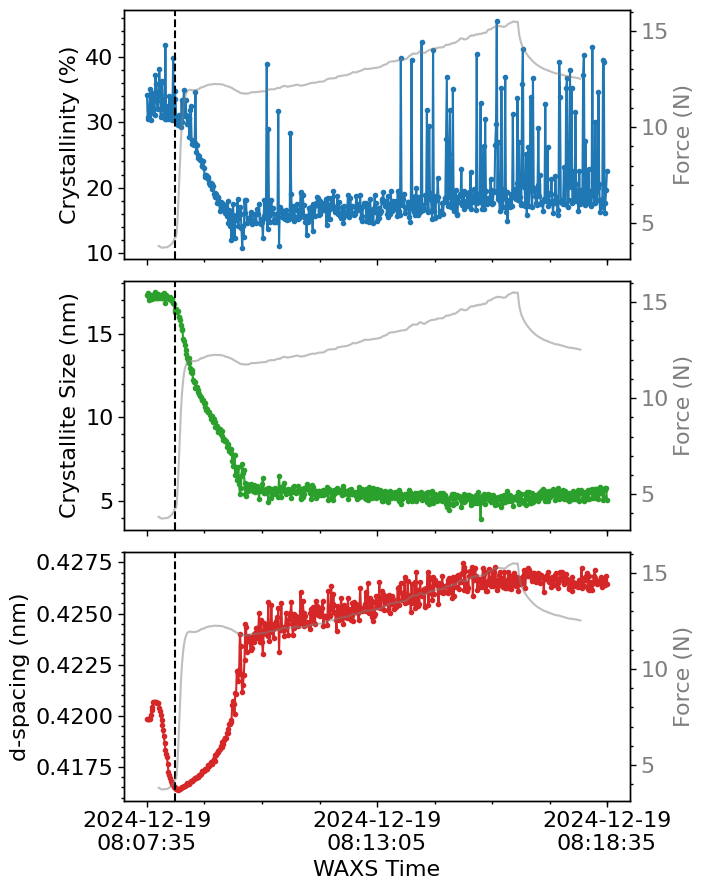

In [ ]:
plot_waxs_with_tensile_overlay(
    folder_path_waxs=folder_path_waxs,
    filename_waxs="crystallinity_Run2_LDPE_5mmmin_01_Scan00001_s00419.xlsx",
    file_path_tensile=file_path_tensile,
    filename_tensile="insitu_Run2_LDPE_5mmmin_01.csv",
    vertical_line_time_str="2024-12-19 00:10:30"
)




plot_waxs_with_tensile_overlay(
    folder_path_waxs=folder_path_waxs,
    filename_waxs="crystallinity_Run16_LDPE_film_3mmmin_01_Scan00001_s00599.xlsx",
    file_path_tensile=file_path_tensile,
    filename_tensile="insitu_Run16_LDPE_film_3mmmin_01.csv",
    vertical_line_time_str="2024-12-19 08:08:16"
)




## P5HV


📂 Processing file: crystallinity_Run17_P5HV_film_5mmmin_01_Scan00001_s00319.xlsx


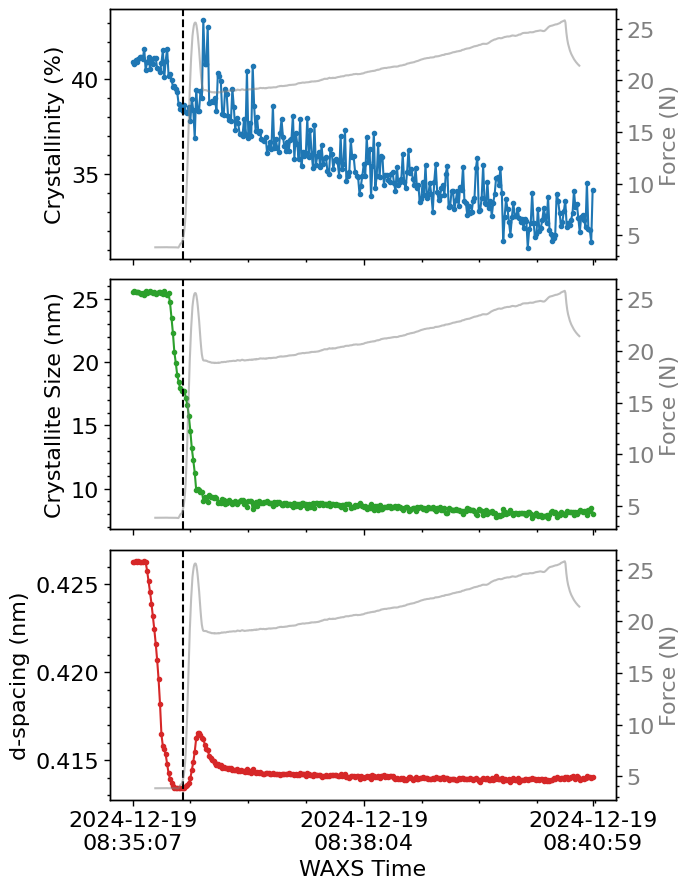


📂 Processing file: crystallinity_Run15_P5HV_film_3mmmin_01_Scan00001_s00599.xlsx


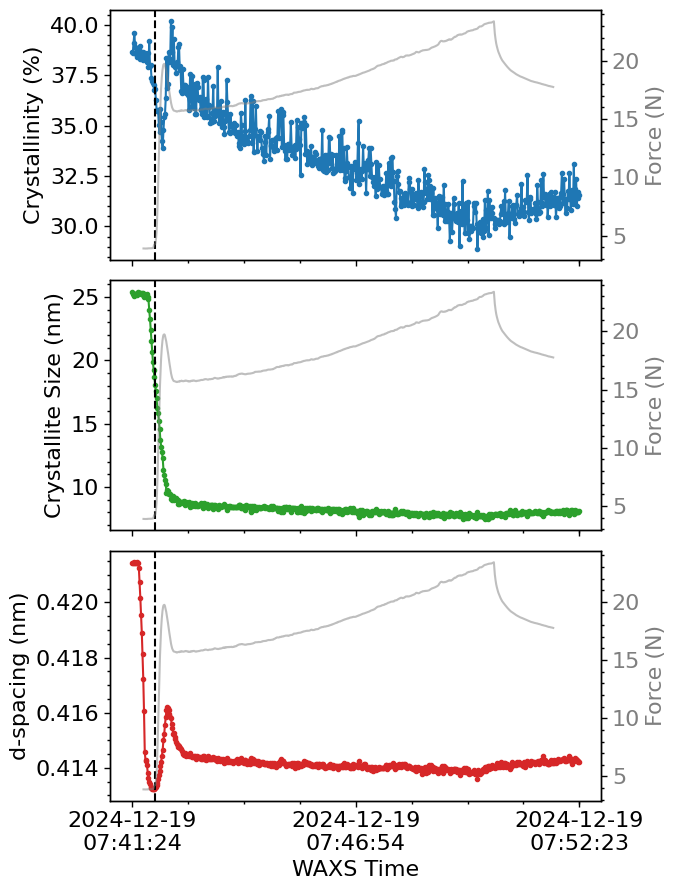

In [202]:
plot_waxs_with_tensile_overlay(
    folder_path_waxs=folder_path_waxs,
    filename_waxs="crystallinity_Run17_P5HV_film_5mmmin_01_Scan00001_s00319.xlsx",
    file_path_tensile=file_path_tensile,
    filename_tensile="insitu_Run17_P5HV_film_5mmmin_01.csv",
    vertical_line_time_str="2024-12-19 8:35:46"
)






plot_waxs_with_tensile_overlay(
    folder_path_waxs=folder_path_waxs,
    filename_waxs="crystallinity_Run15_P5HV_film_3mmmin_01_Scan00001_s00599.xlsx",
    file_path_tensile=file_path_tensile,
    filename_tensile="insitu_Run15_P5HV_film_3mmmin_01.csv",
    vertical_line_time_str="2024-12-19 07:41:58"
)




## PHPD


📂 Processing file: crystallinity_Run9_PHPD_MBfilm_3mmmin_01_Scan00001_s00599.xlsx


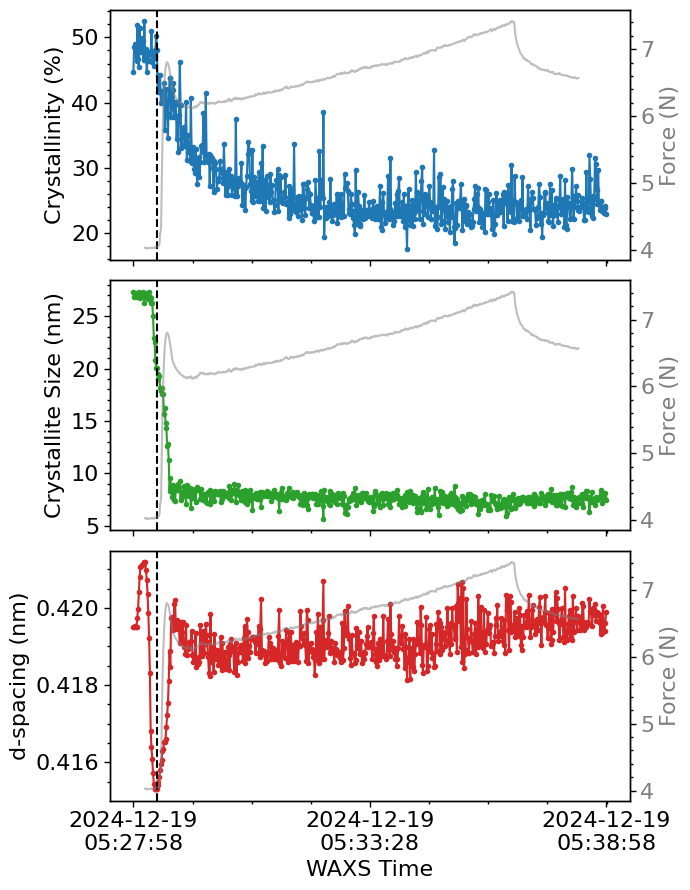


📂 Processing file: crystallinity_Run6_PHPD_film_base_5mmmin_01_Scan00001_s00319.xlsx


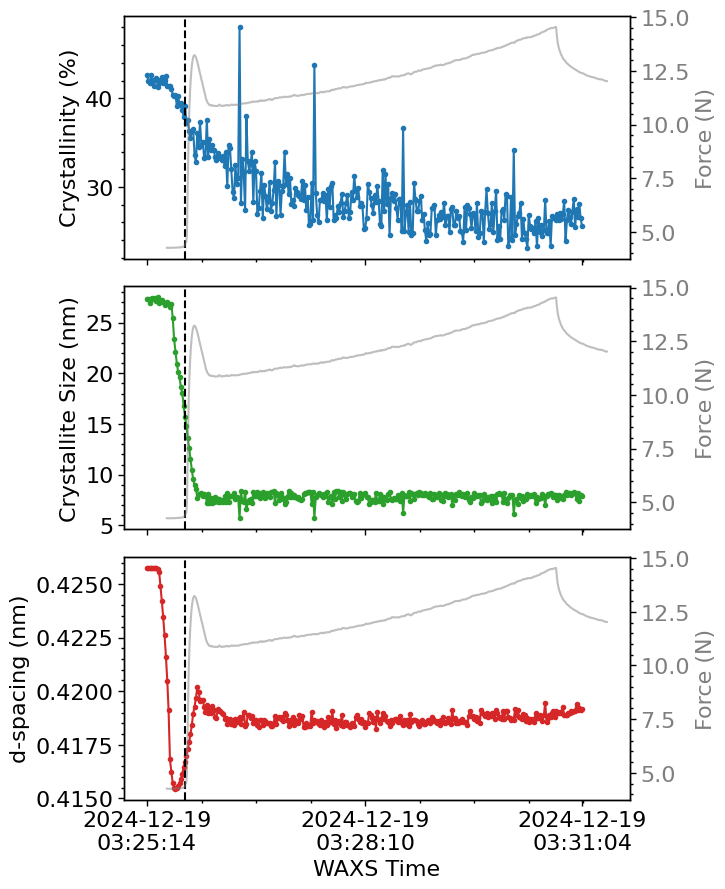


📂 Processing file: crystallinity_Run8_PHPD_film_base_3mmmin_01_Scan00001_s00599.xlsx


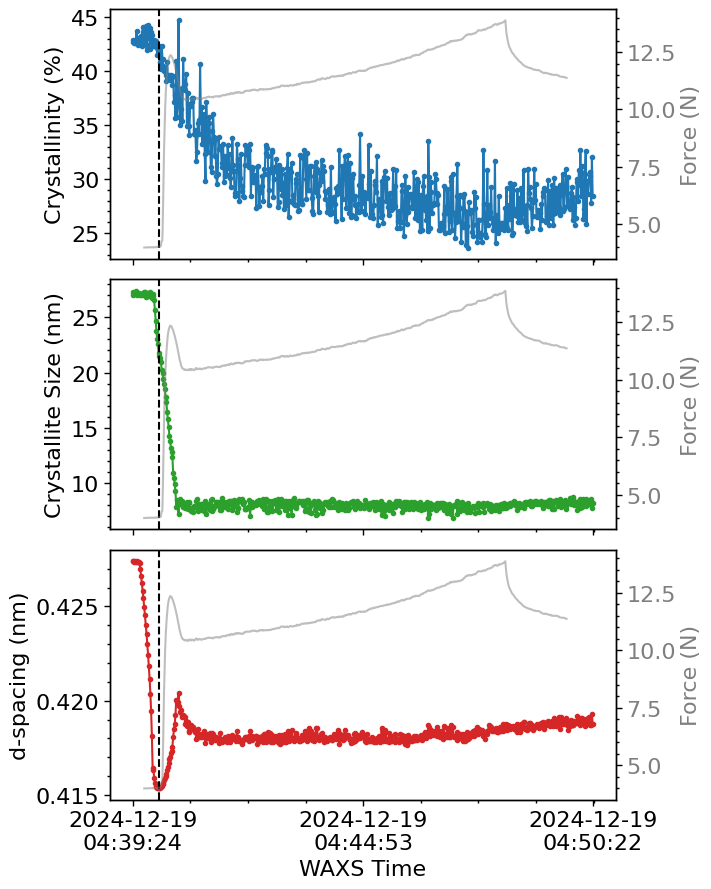

In [203]:
plot_waxs_with_tensile_overlay(
    folder_path_waxs=folder_path_waxs,
    filename_waxs="crystallinity_Run9_PHPD_MBfilm_3mmmin_01_Scan00001_s00599.xlsx",
    file_path_tensile=file_path_tensile,
    filename_tensile="insitu_Run9_PHPD_MBfilm_3mmmin_01.csv",
    vertical_line_time_str="2024-12-19 5:28:32"
)






plot_waxs_with_tensile_overlay(
    folder_path_waxs=folder_path_waxs,
    filename_waxs="crystallinity_Run6_PHPD_film_base_5mmmin_01_Scan00001_s00319.xlsx",
    file_path_tensile=file_path_tensile,
    filename_tensile="insitu_Run6_PHPD_Film_base_5mmmin_01.csv",
    vertical_line_time_str="2024-12-19 03:25:45"
)



plot_waxs_with_tensile_overlay(
    folder_path_waxs=folder_path_waxs,
    filename_waxs="crystallinity_Run8_PHPD_film_base_3mmmin_01_Scan00001_s00599.xlsx",
    file_path_tensile=file_path_tensile,
    filename_tensile="insitu_Run8_PHPD_Film_base_3mmmin_01.csv",
    vertical_line_time_str="2024-12-19 04:40:02"
)


